In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from numpy.linalg import lstsq
%matplotlib inline

对手动测量数据进行处理和拟合，并求出各个峰值

In [14]:
def process_manual(ug, ia,
                   fall_window_V=15.0,
                   min_drop_frac=0.01,
                   min_drop_abs=None,
                   interp_width_pts=2,
                   plot=True,
                   verbose=True,
                   save_csv=None,
                   round_voltage_decimals=1):
    """
    Peak detection and sub-sample refinement using RAW curve only (no smoothing).
    Returns dict with 'selected_raw' and metadata. Saves CSV if save_csv provided.
    """
    import numpy as _np, pandas as _pd
    import matplotlib.pyplot as _plt

    # derivative-based maxima/minima on raw
    if len(ia) < 3:
        raise ValueError("ia array too short")

    d_r = _np.diff(ia)
    maxima_r = [i for i in range(1, len(d_r)) if (d_r[i-1] > 0 and d_r[i] <= 0)]
    minima_r = [i for i in range(1, len(d_r)) if (d_r[i-1] < 0 and d_r[i] >= 0)]

    # convert fall_window_V -> points (assumes ug roughly uniformly spaced)
    if len(ug) > 1:
        vg_step = _np.median(_np.diff(ug))
    else:
        vg_step = 1.0
    fall_window_pts = max(1, int(abs(fall_window_V / vg_step)))

    # thresholds
    ia_min, ia_max = ia.min(), ia.max()
    ia_range = ia_max - ia_min
    if min_drop_abs is None:
        min_drop_abs = ia_range * min_drop_frac

    # helper: find trough after index p on raw arr
    def find_trough_after_raw(p):
        later = [m for m in minima_r if m > p]
        if later:
            t = later[0]
            if t - p > fall_window_pts:
                window_end = min(len(ia)-1, p + fall_window_pts)
                t = p + int(_np.argmin(ia[p:window_end+1]))
        else:
            window_end = min(len(ia)-1, p + fall_window_pts)
            t = p + int(_np.argmin(ia[p:window_end+1]))
        return int(t)

    # helper: quadratic fit around index idx using arr and ug, return refined voltage and value
    def refine_extremum(idx, arr, ug_vals, half_width=interp_width_pts):
        N = len(arr)
        left = max(0, idx - half_width)
        right = min(N - 1, idx + half_width)
        if right - left < 2:
            return float(ug_vals[idx]), float(arr[idx])
        x = ug_vals[left:right+1]
        y = arr[left:right+1]
        try:
            coeff = _np.polyfit(x, y, 2)
            a, b, c = coeff
            if abs(a) < 1e-12:
                return float(ug_vals[idx]), float(arr[idx])
            x_vertex = -b / (2 * a)
            if x_vertex < x[0] - 1e-6 or x_vertex > x[-1] + 1e-6:
                return float(ug_vals[idx]), float(arr[idx])
            y_vertex = a * x_vertex**2 + b * x_vertex + c
            return float(x_vertex), float(y_vertex)
        except Exception:
            return float(ug_vals[idx]), float(arr[idx])

    # select rise-then-fall peaks on raw
    selected_raw = []
    for p in maxima_r:
        if p >= len(ug):
            continue
        t = find_trough_after_raw(p)
        ia_peak_r = float(ia[p])
        ia_trough_r = float(ia[t]) if t > p else ia_peak_r
        drop_r = ia_peak_r - ia_trough_r
        if (t > p) and (drop_r >= min_drop_abs):
            ug_peak_r_ref, ia_peak_r_ref = refine_extremum(p, ia, ug, half_width=interp_width_pts)
            ug_trough_r_ref, ia_trough_r_ref = refine_extremum(t, ia, ug, half_width=interp_width_pts)
            selected_raw.append({
                'peak_idx_raw': int(p),
                'UG2K_raw_V': float(ug[p]),
                'UG2K_raw_V_refined': ug_peak_r_ref,
                'IA_peak_raw': ia_peak_r,
                'IA_peak_raw_refined': ia_peak_r_ref,
                'trough_idx_raw': int(t),
                'UG2K_trough_raw_V': float(ug[t]),
                'UG2K_trough_raw_V_refined': ug_trough_r_ref,
                'IA_trough_raw': ia_trough_r,
                'IA_trough_raw_refined': ia_trough_r_ref,
                'drop_raw': float(drop_r)
            })

    # rounding helper
    def r(v):
        return round(v, round_voltage_decimals) if (v is not None and not _np.isnan(v)) else v

    # verbose print
    if verbose:
        print(f"Raw-detected maxima: {len(maxima_r)}")
        print(f"Selected rise-then-fall peaks (raw-based): {len(selected_raw)}")
        for i, s in enumerate(selected_raw, 1):
            print(f"{i}: UG2K_raw={r(s['UG2K_raw_V_refined']):.{round_voltage_decimals}f} V, IA_raw={s['IA_peak_raw_refined']:.6g}, drop={s['drop_raw']:.6g}")

    # save CSV
    if save_csv is not None and selected_raw:
        rows = []
        for s in selected_raw:
            rows.append({
                'peak_idx': s['peak_idx_raw'],
                'UG2K_V': s['UG2K_raw_V'],
                'UG2K_V_refined': s['UG2K_raw_V_refined'],
                'IA_peak': s['IA_peak_raw'],
                'IA_peak_refined': s['IA_peak_raw_refined'],
                'trough_idx': s['trough_idx_raw'],
                'UG2K_trough_V': s['UG2K_trough_raw_V'],
                'UG2K_trough_V_refined': s['UG2K_trough_raw_V_refined'],
                'IA_trough': s['IA_trough_raw'],
                'IA_trough_refined': s['IA_trough_raw_refined'],
                'drop': s['drop_raw']
            })
        df_out = _pd.DataFrame(rows)
        df_out.to_csv(save_csv, index=False)
        if verbose:
            print(f"Saved selected raw peaks to: {save_csv}")

    # plotting (raw only)
    if plot:
        _plt.figure(figsize=(10,5))
        _plt.plot(ug, ia, label='IA (raw)', lw=1)
        for s in selected_raw:
            _plt.plot(s['UG2K_raw_V_refined'], s['IA_peak_raw_refined'], 'ms', label='raw selected (refined)' if s==selected_raw[0] else "")
            _plt.plot(s['UG2K_trough_raw_V_refined'], s['IA_trough_raw_refined'], 'g^', label='raw trough (refined)' if s==selected_raw[0] else "")
            _plt.plot([s['UG2K_raw_V_refined'], s['UG2K_trough_raw_V_refined']],
                      [s['IA_peak_raw_refined'], s['IA_trough_raw_refined']], 'k--', alpha=0.6)
        _plt.xlabel('UG2K (V)'); _plt.ylabel('IA (arb)')
        _plt.title(f"Selected raw peaks (refined): {len(selected_raw)}")
        _plt.legend(); _plt.tight_layout(); _plt.show()

    return {
        'selected_raw': selected_raw,
        'all_maxima_idx_raw': maxima_r
    }


In [9]:
def process_auto_fit(n, ug, plot=True):
    A = np.vstack([n, np.ones_like(n)]).T
    (a,b), _, _, _ = lstsq(A, ug, rcond=None)
    yfit = a*n + b
    dof = max(1, len(ug)-2)
    s2 = np.sum((ug - yfit)**2)/dof
    cov = s2 * np.linalg.inv(A.T @ A)
    sigma_a, sigma_b = np.sqrt(cov[0,0]), np.sqrt(cov[1,1])

    if plot:
        plt.figure(figsize=(6,4))
        plt.scatter(n, ug, label='data')
        n_line = np.linspace(min(n)-0.5, max(n)+0.5, 200)
        plt.plot(n_line, a*n_line+b, 'r-', label=f'fit: U0={a:.3f} V')
        plt.xlabel('peak index n'); plt.ylabel('UG2K (V)')
        plt.legend(); plt.tight_layout(); plt.show()

    return dict(U0=a, Uc=b, sigma_a=sigma_a, sigma_b=sigma_b)

In [15]:
def manual_data_processing(fname, save_csv="detected_peaks.csv", **kwargs):
    df = pd.read_csv(fname)
    ug = df.iloc[:,0].to_numpy(dtype=float)
    ia = df.iloc[:,1].to_numpy(dtype=float)
    return process_manual(ug, ia, save_csv=save_csv, **kwargs)



Raw-detected maxima: 7
Selected rise-then-fall peaks (raw-based): 7
1: UG2K_raw=18.2 V, IA_raw=159.8, drop=5
2: UG2K_raw=27.9 V, IA_raw=208.425, drop=30
3: UG2K_raw=38.9 V, IA_raw=246.57, drop=42
4: UG2K_raw=50.3 V, IA_raw=283.476, drop=45
5: UG2K_raw=62.2 V, IA_raw=323.16, drop=45
6: UG2K_raw=74.4 V, IA_raw=367.587, drop=38
7: UG2K_raw=87.2 V, IA_raw=419.805, drop=26
Saved selected raw peaks to: detected_peaks.csv


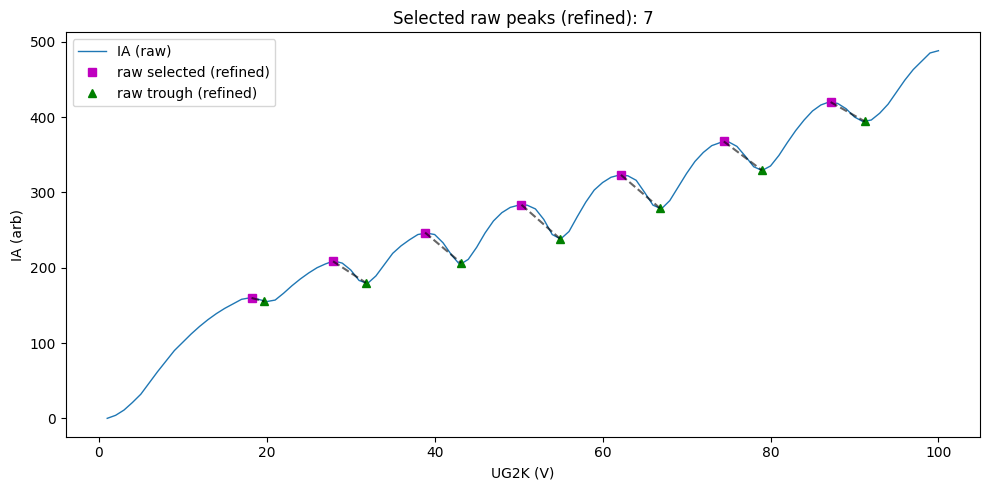

In [17]:
res = manual_data_processing("manual_template.csv",
                                     save_csv="detected_peaks.csv",
                                     fall_window_V=15.0,
                                     min_drop_frac=0.01,
                                     plot=True, verbose=True)



使用线性拟合，计算接触电势差的值

In [21]:
import numpy as np
import pandas as pd
from numpy.linalg import lstsq

def extract_peak_voltages_from_res(res, prefer_refined=True):
    """
    从 process_manual 的返回值（res）提取峰电压数组（升序）。
    res: dict 包含 'selected_raw' 列表（每项为 dict）
    prefer_refined: 优先使用 'UG2K_raw_V_refined' 字段
    """
    peaks = res.get('selected_raw', []) if isinstance(res, dict) else []
    if not peaks:
        # 允许直接传入 DataFrame
        if isinstance(res, pd.DataFrame):
            if 'UG2K_V_refined' in res.columns:
                v = res['UG2K_V_refined'].to_numpy(dtype=float)
            elif 'UG2K_V' in res.columns:
                v = res['UG2K_V'].to_numpy(dtype=float)
            else:
                v = np.array([], dtype=float)
            return np.sort(v)
        return np.array([], dtype=float)
    vals = []
    for p in peaks:
        if prefer_refined and p.get('UG2K_raw_V_refined') is not None:
            vals.append(float(p['UG2K_raw_V_refined']))
        elif p.get('UG2K_raw_V') is not None:
            vals.append(float(p['UG2K_raw_V']))
        elif p.get('UG2K_smooth_V_refined') is not None:
            vals.append(float(p['UG2K_smooth_V_refined']))
        elif p.get('UG2K_smooth_V') is not None:
            vals.append(float(p['UG2K_smooth_V']))
    return np.sort(np.array(vals, dtype=float))

def estimate_contact_potential_from_res(res_or_fname, method='first_peak', save_csv=None, prefer_refined=True):
    """
    计算 U0 和 Uc。
    res_or_fname: process_manual 返回 dict 或者 已保存的 detected_peaks.csv 文件路径 或 DataFrame
    method: 'first_peak' 或 'linear_fit'
    save_csv: 若不为 None，将把用于计算的峰位保存为 CSV
    返回 dict: {'U0':..., 'U0_std':..., 'Uc':..., 'details':...}
    """
    # 读取峰位
    if isinstance(res_or_fname, str):
        df = pd.read_csv(res_or_fname)
        # 尝试多种列名
        if 'UG2K_raw_V_refined' in df.columns:
            ug_vals = np.sort(df['UG2K_raw_V_refined'].to_numpy(dtype=float))
        elif 'UG2K_V_refined' in df.columns:
            ug_vals = np.sort(df['UG2K_V_refined'].to_numpy(dtype=float))
        elif 'UG2K_raw_V' in df.columns:
            ug_vals = np.sort(df['UG2K_raw_V'].to_numpy(dtype=float))
        elif 'UG2K_V' in df.columns:
            ug_vals = np.sort(df['UG2K_V'].to_numpy(dtype=float))
        else:
            raise ValueError("CSV 中找不到峰位列（期望列名例如 'UG2K_raw_V_refined' / 'UG2K_raw_V' / 'UG2K_V_refined' / 'UG2K_V'）")
    elif isinstance(res_or_fname, pd.DataFrame):
        ug_vals = extract_peak_voltages_from_res(res_or_fname, prefer_refined=prefer_refined)
    else:
        ug_vals = extract_peak_voltages_from_res(res_or_fname, prefer_refined=prefer_refined)

    if ug_vals.size < 2:
        raise ValueError("至少需要 2 个峰才能估计 U0 与 Uc。当前检测到峰数: {}".format(ug_vals.size))

    # 保存用于记录的峰位
    if save_csv is not None:
        pd.DataFrame({'UG_peak_V': ug_vals}).to_csv(save_csv, index=False)

    # 方法一：逐差法（mean ΔU）
    dU = np.diff(ug_vals)
    U0_mean = float(np.mean(dU))
    U0_std = float(np.std(dU, ddof=1)) if dU.size > 1 else 0.0
    if method == 'first_peak':
        Uc = float(ug_vals[0] - U0_mean)
        return {'U0': U0_mean, 'U0_std': U0_std, 'Uc': Uc, 'method': 'first_peak', 'dU': dU, 'ug_vals': ug_vals}

    # 方法二：线性拟合 U_n = n * U0 + Uc
    elif method == 'linear_fit':
        n = np.arange(1, ug_vals.size + 1).astype(float)
        A = np.vstack([n, np.ones_like(n)]).T
        (a, b), residuals, rank, s = lstsq(A, ug_vals, rcond=None)
        # a -> U0, b -> Uc
        # 估计不确定度（假设残差方差同方差）
        N = len(ug_vals)
        dof = max(1, N - 2)
        yfit = a * n + b
        s2 = np.sum((ug_vals - yfit) ** 2) / dof
        cov = s2 * np.linalg.inv(A.T @ A)
        sigma_a = float(np.sqrt(cov[0, 0]))
        sigma_b = float(np.sqrt(cov[1, 1]))
        return {'U0': float(a), 'U0_std': sigma_a, 'Uc': float(b), 'Uc_std': sigma_b,
                'method': 'linear_fit', 'residuals_sum': float(np.sum((ug_vals - yfit) ** 2)),
                'ug_vals': ug_vals, 'dU': dU}
    else:
        raise ValueError("method must be 'first_peak' or 'linear_fit'")

In [23]:
# 假设你的数据文件为 manual_data.csv
res = manual_data_processing("manual_template.csv", save_csv="detected_peaks.csv",
                             fall_window_V=15.0, min_drop_frac=0.01, plot=False, verbose=False)

# 用 first_peak 法估计
cp1 = estimate_contact_potential_from_res(res, method='first_peak', save_csv='peaks_used_for_Uc.csv')
print(f"first_peak -> U0={cp1['U0']:.3f} V ± {cp1['U0_std']:.3f} V, Uc={cp1['Uc']:.3f} V")

# 用 linear_fit 法估计
cp2 = estimate_contact_potential_from_res(res, method='linear_fit')
print(f"linear_fit -> U0={cp2['U0']:.3f} V ± {cp2['U0_std']:.3f} V, Uc={cp2['Uc']:.3f} V ± {cp2.get('Uc_std',0):.3f} V")



first_peak -> U0=11.494 V ± 1.065 V, Uc=6.697 V
linear_fit -> U0=11.546 V ± 0.208 V, Uc=5.110 V ± 0.932 V
